In [5]:
!pip install jovian --upgrade --quiet

In [6]:
import jovian 
project_name = 'asl-cnn-resnet'

In [7]:
DATA_DIR = '../input/sign-language-mnist'

In [8]:
import os

print(os.listdir(DATA_DIR))

['sign_mnist_train.csv', 'sign_mnist_test.csv', 'sign_mnist_test', 'sign_mnist_train', 'amer_sign3.png', 'amer_sign2.png', 'american_sign_language.PNG']


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
train_data = pd.read_csv(DATA_DIR + '/sign_mnist_train.csv')
test_data = pd.read_csv(DATA_DIR + '/sign_mnist_test.csv')

In [11]:
train_data.shape, test_data.shape

((27455, 785), (7172, 785))

In [12]:
def dataframe_to_arrays(dataframe):
    
    inputs_array = dataframe.iloc[:, 1:].to_numpy()
    targets_array = dataframe['label'].to_numpy()
    
    return inputs_array, targets_array

In [13]:
inputs_array, targets_array = dataframe_to_arrays(train_data)

inputs_array = np.repeat(inputs_array[...,  np.newaxis], 3, -1).reshape(-1, 28, 28, 3)
inputs_array = inputs_array.transpose(0, 3, 1, 2)

inputs_array.shape, targets_array.shape

((27455, 3, 28, 28), (27455,))

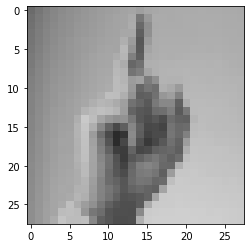

Alphabet :  D


In [14]:
image = inputs_array[0].transpose(1, 2, 0)
plt.imshow(image, cmap = "gray")
plt.show()

print("Alphabet : ", chr(65+targets_array[0]))

In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import random

In [16]:
inputs = torch.tensor(inputs_array , dtype=torch.float32)
targets = torch.tensor(targets_array , dtype=torch.long)

In [17]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = T.Compose([
                            T.ToPILImage(),
                            # T.RandomCrop(32, padding=4, padding_mode='reflect'), 
                            T.Resize(32),
                            T.RandomHorizontalFlip(), 
                            T.ToTensor(), 
                            T.Normalize(*stats,inplace=True)]
                        )
valid_tfms = T.Compose([T.ToPILImage(), T.Resize(32), T.ToTensor(), T.Normalize(*stats)])

In [18]:
class CustomTensorDataset(Dataset):
    
    def __init__(self, tensors, transform=None):
        assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index]

        if self.transform:
            x = self.transform(x)

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].size(0)

In [19]:
val_percent = 0.15 

X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=val_percent, random_state=42)

In [20]:
train_ds = CustomTensorDataset(tensors=(X_train, y_train), transform=train_tfms)
val_ds = CustomTensorDataset(tensors=(X_val, y_val), transform=valid_tfms)

In [21]:
batch_size = 400

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

In [23]:
from torchvision.utils import make_grid

In [24]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

In [25]:
for images, _ in train_dl:
    print(images.shape)
    break
    
for images, _ in val_dl:
    print(images.shape)
    break

torch.Size([400, 3, 32, 32])
torch.Size([800, 3, 32, 32])


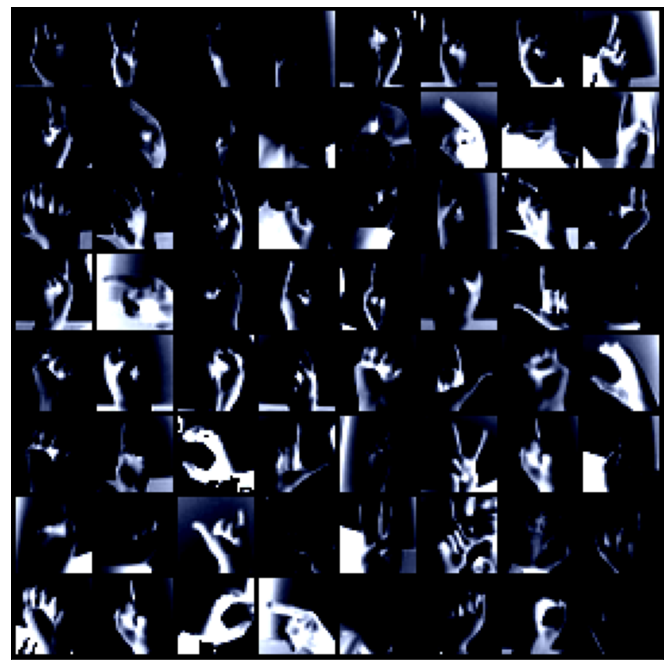

In [26]:
show_batch(train_dl)

In [27]:
def get_default_device():
    
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [28]:
def to_device(data, device):
    
    if isinstance(data, (list, tuple)):
        return [to_device(each, device) for each in data]
    else:
        return data.to(device, non_blocking = True)
    
class DeviceDataLoader():
    
    def __init__(self, dl, device):
        
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        
        return len(self.dl)   

In [29]:
device = get_default_device()
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
inputs_array_test, targets_array_test = dataframe_to_arrays(test_data)

inputs_array_test = np.repeat(inputs_array_test[...,  np.newaxis], 3, -1).reshape(-1, 28, 28, 3)
inputs_array_test = inputs_array_test.transpose(0, 3, 1, 2)

inputs_test = torch.tensor(inputs_array_test , dtype=torch.float32)
targets_test = torch.tensor(targets_array_test , dtype=torch.long)

test_ds = CustomTensorDataset(tensors=(inputs_test, targets_test), transform=valid_tfms)

test_dl = DataLoader(test_ds, batch_size*2, num_workers=3, pin_memory=True)

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [31]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/asl-cnn-resnet


<IPython.core.display.Javascript object>

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                   
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)          
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [34]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        #initial dim : 3 x 32 x 32
        self.conv1 = conv_block(in_channels, 64)
        #dim : 64 x 32 x 32
        self.conv2 = conv_block(64, 128, pool=True)
        #dim : 128 x 16 x 16
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        #dim : 128 x 16 x 16
        self.conv3 = conv_block(128, 256, pool=True)
        #dim : 256 x 8 x 8
        self.conv4 = conv_block(256, 512, pool=True)
        #dim : 512 x 4 x 4
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        #dim : 512 x 4 x 4
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [35]:
model = ResNet9(3, 26)

In [36]:
model = to_device(model, device)
model

In [37]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sreejagaddamidi99/asl-cnn-resnet


<IPython.core.display.Javascript object>

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [39]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [40]:
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            
            lrs.append(get_lr(optimizer))
            sched.step()
        
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [41]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 3.2602007389068604, 'val_acc': 0.043553922325372696}]

In [42]:
epochs = 2
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00004, train_loss: 3.3608, val_loss: 1.9869, val_acc: 0.5377
Epoch [1], last_lr: 0.00009, train_loss: 0.8133, val_loss: 0.2563, val_acc: 0.9840
Epoch [2], last_lr: 0.00010, train_loss: 0.1060, val_loss: 0.0631, val_acc: 0.9983
Epoch [3], last_lr: 0.00008, train_loss: 0.0345, val_loss: 0.0327, val_acc: 0.9996


In [ ]:
evaluate(model, test_dl)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_losses(history)

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

In [ ]:
plot_lrs(history)

In [ ]:
torch.save(model.state_dict(), 'asl-resnet9.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams(arch='resnet9', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                val_acc=history[-1]['val_acc'],
                train_loss=history[-1]['train_loss'],
                # time=train_time
                  )

In [ ]:
jovian.commit(project=project_name, environment=None, outputs=['asl-resnet9.pth'])